<a href="https://colab.research.google.com/github/ArtemChemist/W207-spring-23-anoop-sneha-art/blob/main/W207_project_petridish_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install psutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [2]:
# import
import platform
import os
import io
import requests
import numpy as np
import time
import cv2
import psutil
import gc

In [3]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


**Memory Usage**

In [4]:
#Check if GPU is being used

device_name = tf.test.gpu_device_name()
if device_name != "":
    print(f"GPU: {device_name}")
else:
    print("No GPU found.")


GPU: /device:GPU:0


In [5]:
# Get memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

def get_total_memory():
  tot_mem = psutil.virtual_memory().total
  return tot_mem / (1024 ** 2)  # Return total memory  in MB

def get_available_memory():
  avail_mem = psutil.virtual_memory().available
  return avail_mem / (1024 ** 2)  # Return available memory in MB

# Get CPU usage
def get_cpu_usage():
    return psutil.cpu_percent()

def print_time_memory_detail(start_time, end_time):
  print(f"Time taken: {end_time - start_time:.4f} seconds")
  print(f"Total Memory: {get_total_memory():.2f} MB")
  print(f"Available Memory: {get_available_memory():.2f} MB")
  print(f"Memory usage: {get_memory_usage():.2f} MB")
  print(f"CPU usage: {get_cpu_usage()}%")
  return ""

# Print OS information
print(f"OS: {platform.system()} {platform.release()} ({platform.version()})")

# Print number of vCPUs
num_vcpus = os.cpu_count()
print(f"vCPUs: {num_vcpus}")

# Print GPU information
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv


OS: Linux 5.10.147+ (#1 SMP Sat Dec 10 16:00:40 UTC 2022)
vCPUs: 4
name, driver_version, memory.total [MiB]
Tesla T4, 525.85.12, 15360 MiB


**Authenticate**

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Define the shared file link - origninal
file_link_orig = "https://drive.google.com/drive/folders/1hhbkIRn3Kk-_AVMVaoqYBA1mQh7LAj7H?usp=share_link"

# cleaned images - Thresholded
file_link = "https://drive.google.com/drive/folders/1wpbkFd31H7T9ypZ3Sp0PuZePZWQlNqMe"

# Extract the file ID from the link
folder_id_1 = file_link.split("/")[-1]
# Remove the part after "?"
folder_id = folder_id_1.split("?")[0]

print('main dataset folder id', folder_id)

main dataset folder id 1wpbkFd31H7T9ypZ3Sp0PuZePZWQlNqMe


**Get the file details**

In [7]:
# Define the MIME type of the JPEG files
mime_type = "image/jpeg"

# Define the Google Drive API service
service = build("drive", "v3")

# Define the query to retrieve the JPEG files in the folder
query = "mimeType='{}' and parents='{}'".format(mime_type, folder_id)

# Execute the query and retrieve the list of JPEG files
page_token = ""
filelist = {}
while True:
    response = service.files().list(q=query,
                                supportsAllDrives='true',
                                includeItemsFromAllDrives='true',
                                pageSize=1000,
                                fields='nextPageToken, files(id, name)',
                                pageToken=page_token).execute()

    page_token = response.get('nextPageToken', None)
    filelist.setdefault("files",[]).extend(response.get('files'))

    if (not page_token):
        break

items = filelist['files']


print("Number of Files in man dataset: ",len(items))

Number of Files in man dataset:  3743


In [8]:
# loop through all files and generate labels from teh names, save the contents to a dict
# Last digit in the file name - number of colonies that expert found
# If there are any colonies we call the case positive, the sample is not sterile
image_names = []
id_dict = {}
labels = []
for item in items:
    id_dict[item["name"]] = item["id"]
    image_names.append(item["name"])
    num_colonies = int(image_names[-1].split('-')[2].strip().split('.')[0])
    if num_colonies == 0:
      labels.append(0)
    else:
      labels.append(1)
image_names = np.array(image_names)
labels = np.array(labels)

**Create Data Set**

In [9]:
#  Get two arrays with filenames for positive and negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'There are {num_pos} images with bacteria and {num_neg} without')

There are 315 images with bacteria and 3428 without


In [10]:
#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0)
idx = np.random.choice(np.arange(neg_im_files.shape[0]), num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
#  (3) Make a full set of file names, with X and y, not split into train.test yet
X_files = np.concatenate((pos_im_files,neg_selected_files), axis =0)
y = np.concatenate((np.ones(num_pos), np.zeros(neg_selected_files.shape[0])))
print(X_files.shape, y.shape)

(630,) (630,)


In [11]:
# Now shuffle the names
num_datapoints = X_files.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled_files = X_files[shuffled_indices]
y_shuffled = y[shuffled_indices]

**Load Images**

In [12]:
SIZE = 512 #Target image size

In [13]:
start_time = time.time()

# Read and pre-process files of main dataset:
images = []
for i, file_name in enumerate(X_shuffled_files):
    # Get the file from Google Drive
    file_id = id_dict[file_name]
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile(file_name)

    #Resize image
    img = cv2.imread(file_name)
    img = cv2.resize(img, (SIZE,SIZE))
    images.append(img)

    # Print the pixel size of the image
    print(f"file #{i}: {file_name} ID: {file_id} Pixel size: {img.shape}" )

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()
# Conver to NumPy array
X_shuffled = np.array(images)

file #0: 151802e0089d6c38692b816a20706020-102-0.jpg ID: 1MbEc3MvjLiV9leeSHW1EbEjx8tu-9g-9 Pixel size: (512, 512, 3)
file #1: 59b79935159a11be9157434931269d37-100-1.jpg ID: 1gssHaLAo8eoXcyCX7rKF1aOhIQ2vesQ6 Pixel size: (512, 512, 3)
file #2: dbc5fc3143e46143c4955a3afd8b0ced-190-1.jpg ID: 1RGDEtphs-Bk3d2rDwGTXebXNcZ1Js8no Pixel size: (512, 512, 3)
file #3: fe5d125ea5001aade963b62ca30ade18-245-1.jpg ID: 10POYkxxUsDoiIDmB4h9F3kJazge-YYg6 Pixel size: (512, 512, 3)
file #4: f9dce8c4a8e687dd7ca9445b575ec4d7-214-0.jpg ID: 1-mXTOUqvwej29sIT3zsMcgDOQG_yc8HA Pixel size: (512, 512, 3)
file #5: 132a2a5598ac3526040e07213f970da9-126-0.jpg ID: 1c_bfmH95A69Q2B5nwqOZvZrD-VISRFaG Pixel size: (512, 512, 3)
file #6: 89251dafbd7db20a1a2d593e9ecf187f-104-1.jpg ID: 14H6yFQyCz6XgidYST5EafkyvB2J_bDGe Pixel size: (512, 512, 3)
file #7: 15c25e12a08cb7b43590010103eec272-64-2.jpg ID: 1Zb8fl-y5HkSKVBi6sawmGzTHbyYb1Jgb Pixel size: (512, 512, 3)
file #8: c12d1281dad893b5e6e9a65b876d799f-192-2.jpg ID: 1MPyi0rEfBtxWj9Mw

**Visualize 10 images of the dataset, along with thte labels**





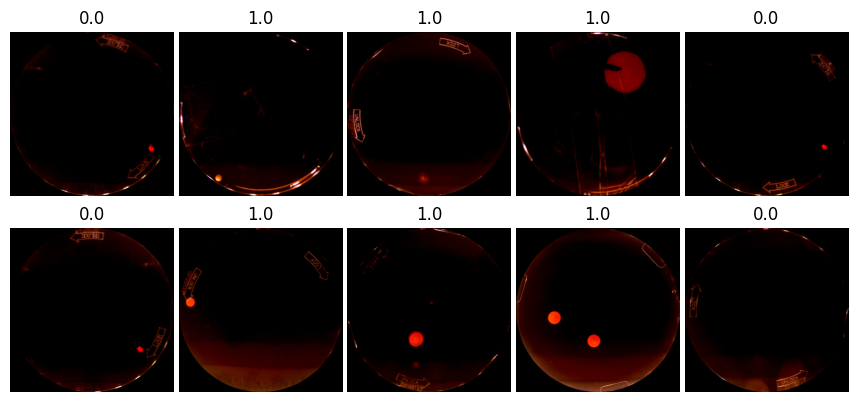

In [20]:
0# Visualize first 10 images of the main dataset to make sure it makes sense
num_rows=2
num_ncols=5
fig, axs = plt.subplots(nrows=num_rows, ncols=num_ncols, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(num_rows) for j in np.arange(num_ncols)]:
    idx = 5*i+j
    image = X_shuffled[idx]
    axs[i,j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_shuffled[idx])
    axs[i,j].axis('off')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.4, wspace=0.02, hspace=0.2)
plt.show()

**Common Constants**

In [27]:
# Set the batch size for training
BATCH_SIZE = 32

# Set the number of epochs for training
EPOCHS = 40

TEST_SIZE = 0.2

RANDOM_STATE = 42

FILTERS = 16

# Set the desired accuracy threshold
ACCURACY_THRESHOLD = 0.9

# Define the image size and input_shape
IMG_SIZE = (SIZE, SIZE)
INPUT_SHAPE = (*IMG_SIZE, 3)

num_classes = max(y_shuffled) + 1

**Common Code** - Prepare Data

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def prepare_data_NEW(X_shuffled, y_shuffled, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=random_state)

    # One-hot encode the labels
    num_classes = np.max(labels) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    return X_train, X_val, y_train, y_val


In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def prepare_data(X_shuffled, y_shuffled, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=random_state)

    # Convert labels to integers
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)

    # One-hot encode the labels
    num_classes = max(np.max(y_train), np.max(y_val)) + 1
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    return X_train, X_val, y_train, y_val


**Common Code** - Evaluate Model

In [48]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

def evaluate_model(model, history, X_val, y_val):
    # Evaluate the model
    y_true = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)

    y_pred_dense = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    # Convergence time
    convergence = history.history['loss'][-1]

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    #Plot precision and recall
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred[:,1], name="CNN Model")
    _ = display.ax_.set_title("Precision-Recall curve")
    _ = display.ax_.set_xlim(0.5,1)
    _ = display.ax_.set_ylim(0.5,1)

    return f1, accuracy, convergence

def evaluate_RF_model(model, X_val, y_val):
    y_true = np.argmax(y_val, axis=1)
    y_pred_dense = np.argmax(RF_model.predict(X_val), axis=1)
    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)

    #Plot confusion matrics
    cm = confusion_matrix(y_true, y_pred_dense)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

    f1 = f1_score(y_true, y_pred_dense, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_dense)
    recall = recall_score(y_true, y_pred_dense)

    return f1, accuracy, recall


**Early Stopping Threshold**

In [25]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, threshold):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy is not None and val_accuracy >= self.threshold:
            self.model.stop_training = True
            print(f"\nStopping training: Validation accuracy reached {self.threshold:.2f}")

# Create the early stopping callback
early_stopping = EarlyStoppingAtAccuracy(ACCURACY_THRESHOLD)

Model - 1 **CNN Model**

In [32]:
from keras.layers.normalization import batch_normalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def make_conv_layers(input_shape):

    conv_layers = Sequential()

    # Zero'th convolutional layer
    conv_layers.add(Conv2D(16, (7, 7), activation='relu', input_shape=input_shape))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # First convolutional layer
    conv_layers.add(Conv2D(32, (9, 9), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    conv_layers.add(Conv2D(64, (11, 11), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    conv_layers.add(Conv2D(128, (13, 13), activation='relu'))
    conv_layers.add(batch_normalization.BatchNormalization())
    conv_layers.add(MaxPooling2D(pool_size=(2, 2)))

    conv_layers.add(Flatten())

    return conv_layers

def create_cnn_model(conv_layers, num_classes):
    conv_layers.add(Dense(128, activation='relu'))
    conv_layers.add(Dropout(0.5))
    conv_layers.add(Dense(num_classes, activation='softmax'))
    return conv_layers


**Run CNN Model**

In [33]:
start_time = time.time()

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Define the CNN model
# Make it so that we would have a pointer to convolutional layers
conv_layers = make_conv_layers(INPUT_SHAPE)
cnn_model = create_cnn_model(conv_layers, num_classes)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create lower early stopping callback for this model, as it is easily overtrianed
# early_stopping_low = EarlyStoppingAtAccuracy(0.85)

# Train the model with the early stopping callback
cnn_history = cnn_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Epoch 1/40
 6/16 [==========>...................] - ETA: 2s - loss: 10.8074 - accuracy: 0.5573

16/16 [==============================] - 32s 1s/step - loss: 5.2558 - accuracy: 0.6389 - val_loss: 148.1615 - val_accuracy: 0.5794
Epoch 2/40
16/16 [==============================] - 4s 268ms/step - loss: 1.1566 - accuracy: 0.7024 - val_loss: 22.1881 - val_accuracy: 0.5873
Epoch 3/40
16/16 [==============================] - 4s 268ms/step - loss: 1.2294 - accuracy: 0.7163 - val_loss: 4.3148 - val_accuracy: 0.6270
Epoch 4/40
16/16 [==============================] - 4s 267ms/step - loss: 0.4484 - accuracy: 0.7798 - val_loss: 2.6837 - val_accuracy: 0.6270
Epoch 5/40
16/16 [==============================] - 4s 269ms/step - loss: 0.5406 - accuracy: 0.7698 - val_loss: 1.0930 - val_accuracy: 0.7143
Epoch 6/40
16/16 [==============================] - 4s 268ms/step - loss: 0.5229 - accuracy: 0.7421 - val_loss: 1.1082 - val_accuracy: 0.6587
Epoch 7/40
16/16 [==============================] - 4s 270ms/step - loss: 0.5231 - accuracy: 0.7857 - val_loss: 0.4876 - val_accuracy: 0.7619
Epoch 8/40
16/16

8

**Evaluate CNN Model**

4/4 [==============================] - 0s 93ms/step
F1 score: 0.5492
Accuracy: 0.6190
Convergence time: 0.2928

Time taken: 0.7946 seconds
Total Memory: 26065.04 MB
Available Memory: 18631.42 MB
Memory usage: 6396.03 MB
CPU usage: 4.3%


''

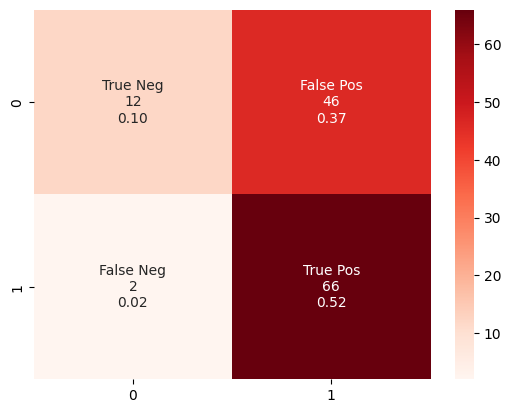

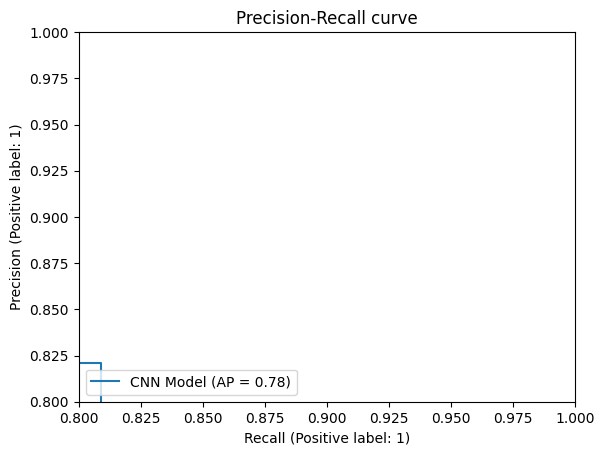

In [34]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(cnn_model, cnn_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


Model - 1.1 **Random Forest on Conv layers of home made CNN**

In [39]:
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

#Make a forward pass through convolutional layers
#This will be a set of features to train RF
X_for_RF = conv_layers.predict(X_train) 

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

16/16 [==============================] - 1s 80ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

4/4 [==============================] - 0s 90ms/step
F1 score: 0.7302
Accuracy: 0.7381
Recall: 0.8824



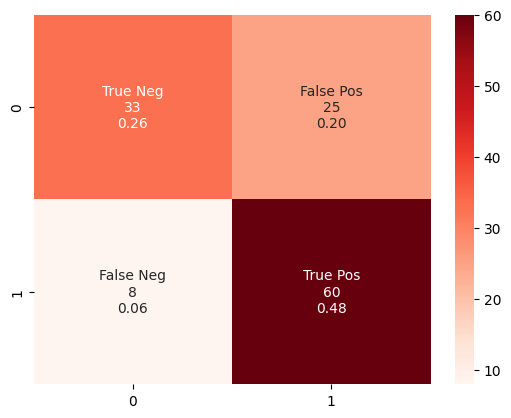

In [40]:
# Evaluate RF model
#Send test data through same feature extractor process
X_test_feature = conv_layers.predict(X_val)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_val)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"")

Model 2 - **Efficient Net**

In [44]:
start_time = time.time()

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
efficientnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Freeze the base model's layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the early stopping callback
efficientnet_history = efficientnet_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()



16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/40
16/16 [==============================] - 17s 653ms/step - loss: 0.6378 - accuracy: 0.6111 - val_loss: 0.5477 - val_accuracy: 0.6746
Epoch 2/40
16/16 [==============================] - 5s 339ms/step - loss: 0.4459 - accuracy: 0.8274 - val_loss: 0.4678 - val_accuracy: 0.7619
Epoch 3/40
16/16 [==============================] - 5s 340ms/step - loss: 0.3818 - accuracy: 0.8433 - val_loss: 0.4249 - val_accuracy: 0.8175
Epoch 4/40
16/16 [==============================] - 5s 340ms/step - loss: 0.3677 - accuracy: 0.8393 - val_loss: 0.3883 - val_accuracy: 0.8413
Epoch 5/40
16/16 [==============================] - 5s 341ms/step - loss: 0.3333 - accuracy: 0.8810 - val_loss: 0.3615 - val_accuracy: 0.8413
Epoch 6/40
16/16 [==============================] - 5s 341ms/step - loss: 0.3225 - accuracy: 0.8730 - val_loss: 0.3665 - val_accuracy: 0.8413
Epoch 7/40
16/16 [==============================] - 5s 341ms/step - loss: 0.3024 -

4

**Evaluate EfficientNet**

4/4 [==============================] - 2s 264ms/step
F1 score: 0.8807
Accuracy: 0.8810
Convergence time: 0.1676

Time taken: 2.6587 seconds
Total Memory: 26065.04 MB
Available Memory: 16579.08 MB
Memory usage: 8264.86 MB
CPU usage: 4.7%


''

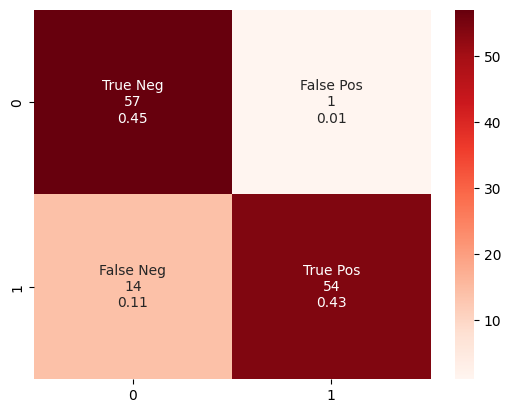

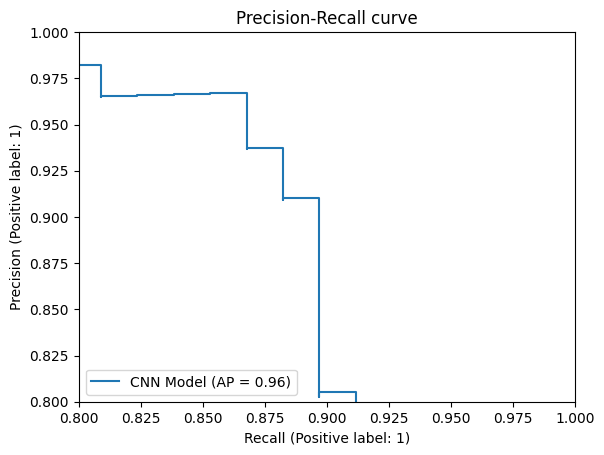

In [45]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(efficientnet_model,efficientnet_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


Model 3 - **ResNet50 Model**

In [53]:
start_time = time.time()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the base model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
resnet50_history = resnet50_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/40
15/15 [==============================] - 19s 775ms/step - loss: 0.7452 - accuracy: 0.5740 - val_loss: 0.7423 - val_accuracy: 0.4706
Epoch 2/40
15/15 [==============================] - 6s 435ms/step - loss: 0.5188 - accuracy: 0.7748 - val_loss: 0.5702 - val_accuracy: 0.6863
Epoch 3/40
15/15 [==============================] - 7s 480ms/step - loss: 0.4446 - accuracy: 0.8190 - val_loss: 0.4446 - val_accuracy: 0.8627
Epoch 4/40
15/15 [==============================] - 7s 444ms/step - loss: 0.4086 - accuracy: 0.8433 - val_loss: 0.4833 - val_accuracy: 0.7451
Epoch 5/40
15/15 [==============================] - 7s 442ms/step - loss: 0.4072 - accuracy: 0.8278 - val_loss: 0.4224 - val_accuracy: 0.8235
Epoch 6/40
15/15 [==============================] - 7s 445ms/step - loss: 0.3780 - accuracy: 0.8433 - val_loss: 0.4766 - val_accuracy: 0.7451
Epoch 7/40
15/15 [==============================] - 7s 447ms/step - loss: 0.3895 -

40481

**Evaluate ResNet50 Model**

4/4 [==============================] - 7s 2s/step
F1 score: 0.8890
Accuracy: 0.8889
Convergence time: 0.1661

Time taken: 6.8633 seconds
Total Memory: 26065.04 MB
Available Memory: 16428.58 MB
Memory usage: 8427.87 MB
CPU usage: 17.1%


''

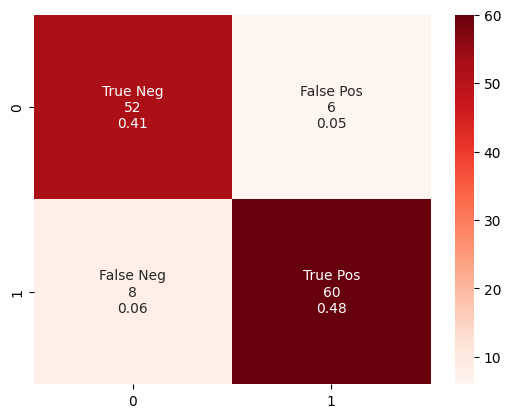

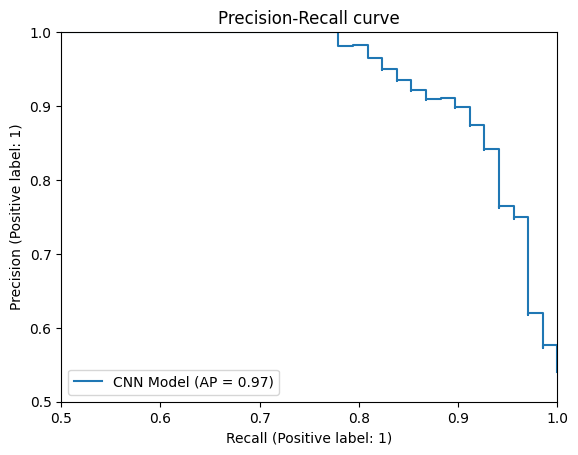

In [54]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(resnet50_model,resnet50_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


Model 4 -**VGG16 Model**

In [28]:

start_time = time.time()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Preprocess the images using the VGG16 preprocessing function
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Create the base model using VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')

# Train the model
#vgg16_history = vgg16_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[early_stopping])
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[early_stopping])

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Epoch 1/40
15/15 [==============================] - 49s 2s/step - loss: 16.0432 - accuracy: 0.5938 - val_loss: 12.5277 - val_accuracy: 0.6863
Epoch 2/40
15/15 [==============================] - 10s 648ms/step - loss: 4.4430 - accuracy: 0.8477 - val_loss: 8.8438 - val_accuracy: 0.7451
Epoch 3/40
15/15 [==============================] - 10s 654ms/step - loss: 1.0325 - accuracy: 0.9404 - val_loss: 7.0417 - val_accuracy: 0.8039
Epoch 4/40
15/15 [==============================] - 10s 663ms/step - loss: 0.2847 - accuracy: 0.9801 - val_loss: 8.1127 - val_accuracy: 0.8235
Epoch 5/40
15/15 [==============================] - 10s 668ms/step - loss: 0.0870 - accuracy: 0.9890 - val_loss: 9.4614 - val_accuracy: 0.7843
Epoch 6/40
15/15 [==============================] - 10s 666ms/step - loss: 9.2501e-05 - accuracy: 1.0000 - val_loss: 6.7493 - val_accuracy: 0.7647
Epoch 7/40
15/15 [==============================] - 10s 660ms/step - loss: 0.0165 - accuracy: 0.9978 - val_loss: 9.4316 - val_accuracy: 0.8

25455

4/4 [==============================] - 18s 6s/step
F1 score: 0.8329
Accuracy: 0.8333
Convergence time: 0.0000

Time taken: 18.7780 seconds
Total Memory: 26065.04 MB
Available Memory: 18039.90 MB
Memory usage: 7015.93 MB
CPU usage: 5.0%


''

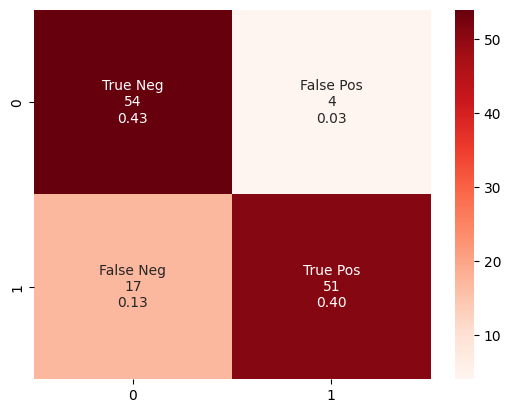

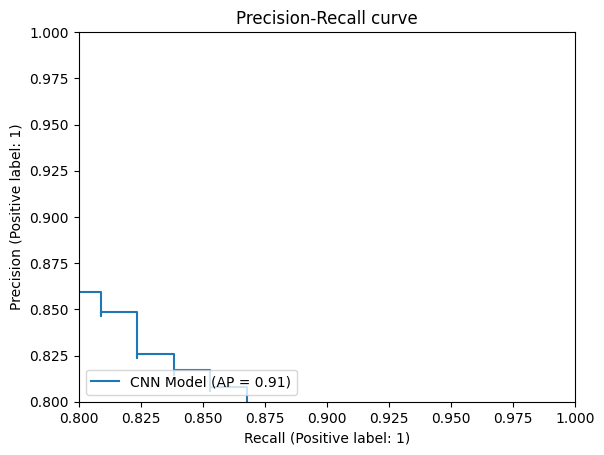

In [29]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(vgg16_model,vgg16_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


Model 5 - **Resnet Model - Sequence 2**

In [ ]:
start_time = time.time()

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


resnet_model2 = Sequential()
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  pooling='avg',
                                                  weights='imagenet')
for layer in pretrained_model.layers:
  layer.trainable=False

resnet_model2.add(pretrained_model)
resnet_model2.add(Flatten())
resnet_model2.add(Dense(512, activation='relu'))
resnet_model2.add(Dense(2, activation='softmax'))

resnet_model2.summary()

resnet_model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

resnet_history2 = resnet_model2.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Evaluate Resnet Model Sequence 2

In [ ]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(resnet_model2,resnet_history2, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


Model 6- **Inception Model**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

start_time = time.time()

Inception_model = InceptionV3(input_shape = INPUT_SHAPE, include_top = False, weights = 'imagenet')

for layer in Inception_model.layers:
    layer.trainable = False

x = keras.layers.Flatten()(Inception_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(2, activation='sigmoid')(x)

final_inception_model = tf.keras.models.Model(Inception_model.input, x)

final_inception_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])


# prepare data
X_train, X_val, y_train, y_val = prepare_data(X_shuffled, y_shuffled)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inception_history = final_inception_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

end_time = time.time()
print_time_memory_detail(start_time, end_time)

print("forcing gc..")
gc.collect()

Evaluate Inception Model

In [ ]:
start_time = time.time()
# Evaluate Model:
f1, accuracy, convergence = evaluate_model(final_inception_model,inception_history, X_val, y_val)
end_time = time.time()

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Convergence time: {convergence:.4f}")
print(f"")

print_time_memory_detail(start_time, end_time)


### Compare models on benchmark dataset

**Load benchmark dataset**

This is a 14% subsection of the original dataset that was separated early on  and was not used for training. This dataset is represenative of the original dataset - highly biased toward the negative cases.

In [36]:
#Benchmark set, shard on GDrive with everybody in the UC Berkeley organization
file_link_benchmark = "https://drive.google.com/drive/folders/1eUee9UuJLHpH-pghmdvZ1lZ__9ry3hGb?usp=share_link"

# Get the folder ID for benchmark data
folder_id_1 = file_link_benchmark.split("/")[-1]
folder_id_bnmrk = folder_id_1 .split("?")[0] 
print('benchmark dataset folder id', folder_id_bnmrk )

# Query GDrive and get a dict of files and ID's in the benchhmark dataset
query = "mimeType='{}' and parents='{}'".format(mime_type, folder_id_bnmrk)
page_token = ""
filelist_bnmrk = {}
while True:
    response = service.files().list(q=query,
                                supportsAllDrives='true',
                                includeItemsFromAllDrives='true',
                                pageSize=1000,
                                fields='nextPageToken, files(id, name)',
                                pageToken=page_token).execute()

    page_token = response.get('nextPageToken', None)
    filelist_bnmrk.setdefault("files",[]).extend(response.get('files'))

    if (not page_token):
        break

items_bnmrk = filelist_bnmrk['files']
print("Number of Files in benchmark dataset: ",len(items_bnmrk))


# loop through all files and generate labels from the names, save names in a list
# also put names of the files in the list as well
# Last digit in the file name - number of colonies that expert found
# If there are any colonies we call the case positive, the sample is not sterile

names_bnmrk = []
id_dict_bnmrk = {}
labels_bnmrk = []
for item in items_bnmrk:
    id_dict_bnmrk[item["name"]] = item["id"]
    names_bnmrk.append(item["name"])
    num_colonies = int(names_bnmrk[-1].split('-')[2].strip().split('.')[0])
    if num_colonies == 0:
      labels_bnmrk.append(0)
    else:
      labels_bnmrk.append(1)

y_bnmrk = np.array(labels_bnmrk)

#Load the actual files, resize them to the same size as training dataset
start_time = time.time()

print(f"Loading benchmark images" )
images_bnmrk = []
for i, file_name in enumerate(names_bnmrk):
    # Get the file from Google Drive
    file_id = id_dict_bnmrk[file_name]
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile(file_name)
    img = cv2.imread(file_name)
    img = cv2.resize(img, (SIZE,SIZE))
    images_bnmrk.append(img)

    # Print the pixel size of the image
    print(f"file #{i}: {file_name} ID: {file_id} Pixel size: {img.shape}" )

end_time = time.time()
print_time_memory_detail(start_time, end_time)


print("forcing gc..")
gc.collect()

# Normalize benchmark dataset
X_bnmrk = np.array(images_bnmrk)



benchmark dataset folder id 1eUee9UuJLHpH-pghmdvZ1lZ__9ry3hGb
Number of Files in benchmark dataset:  609
Loading benchmark images
file #0: 3dc4256b6fe0ad73805fcc95d21fe205-269-2.jpg ID: 1SQiR_OJlx0FRSuP_WN6xbX7eZzIF0M1y Pixel size: (512, 512, 3)
file #1: b68456dc87bce018b828deeb139ceb01-166-0.jpg ID: 1_qzZBJjvB8ywT_gXbZqbi5odlLVS8TS1 Pixel size: (512, 512, 3)
file #2: c95c65bc7eaa07c59143983a7c0bfd72-99-0.jpg ID: 1WZJulF0lwgVedZvyfx9Htn1jORpnHApN Pixel size: (512, 512, 3)
file #3: bb556b1e1ee5b493de3cd086baec987a-128-0.jpg ID: 11puuYRhynQqtXN_iHJrwbkB8xc1yUIkM Pixel size: (512, 512, 3)
file #4: 292164a54337fd8f3a2303edeb9ae9ae-102-0.jpg ID: 1bcC-SiRNq7WgmXPPLRNxe1nK56GYhZCt Pixel size: (512, 512, 3)
file #5: 84599d4853099827678d20b38ed36fce-236-0.jpg ID: 1LEh69_K-J3_bFwrzl-yNh_fD9Kh8M_PO Pixel size: (512, 512, 3)
file #6: 6ecb5153b0550c66347dd573e8fde913-193-0.jpg ID: 1ZAn2LOR4cGH8N7Br1_87wzfkd-Z-QrxG Pixel size: (512, 512, 3)
file #7: 7a70ae9cc58b273514904d3a9cedd436-334-0.jpg ID: 1hS

**Evaluate an in-house made CNN on benchmark dataset**

20/20 [==============================] - 2s 79ms/step
F1 score: 0.2907
Accuracy: 0.2447



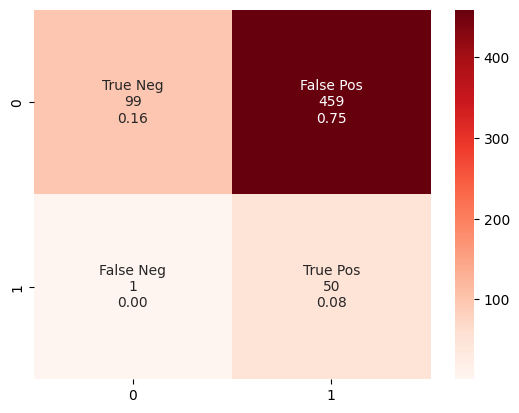

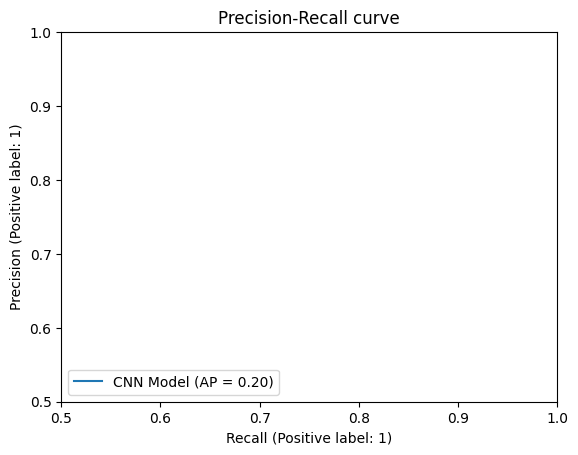

In [50]:
y_bnmrk_onehot = to_categorical(labels_bnmrk, num_classes=2)

f1, accuracy, convergence = evaluate_model(cnn_model, cnn_history, X_bnmrk, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"")

20/20 [==============================] - 2s 79ms/step
F1 score: 0.6873
Accuracy: 0.5993
Recall: 0.7255



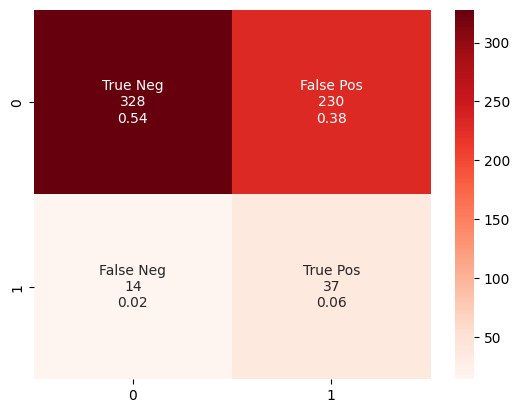

In [46]:
# Evaluate RF model
#Send test data through same feature extractor process

X_test_feature = conv_layers.predict(X_bnmrk)

f1, accuracy, recall = evaluate_RF_model(RF_model, X_test_feature, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"")

**Evaluate EffNet model on the benchmark data**

20/20 [==============================] - 5s 252ms/step
F1 score: 0.9534
Accuracy: 0.9524



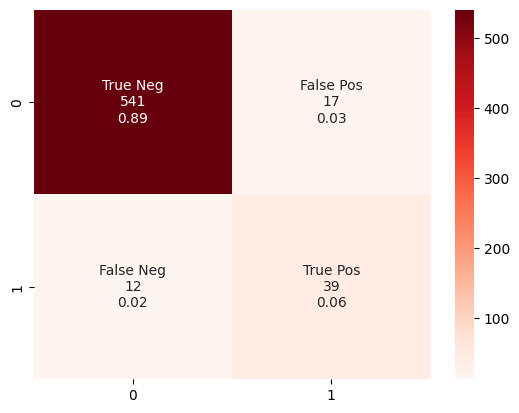

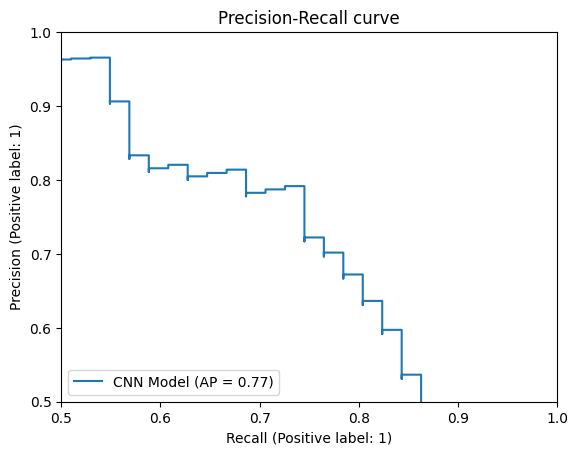

In [49]:
y_bnmrk_onehot = to_categorical(labels_bnmrk, num_classes=2)

f1, accuracy, convergence = evaluate_model(efficientnet_model,efficientnet_history, X_bnmrk, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"")

**Evaluate vgg16 model on the benchmark data**

20/20 [==============================] - 12s 614ms/step
F1 score: 0.3103
Accuracy: 0.2594



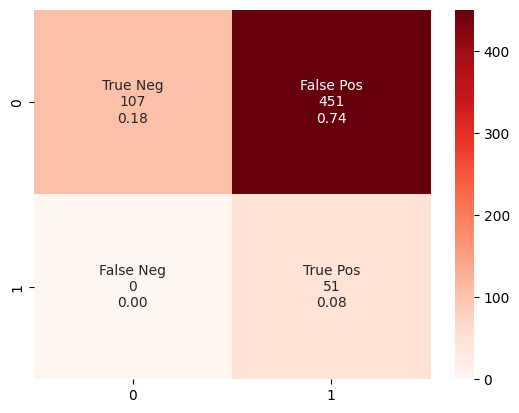

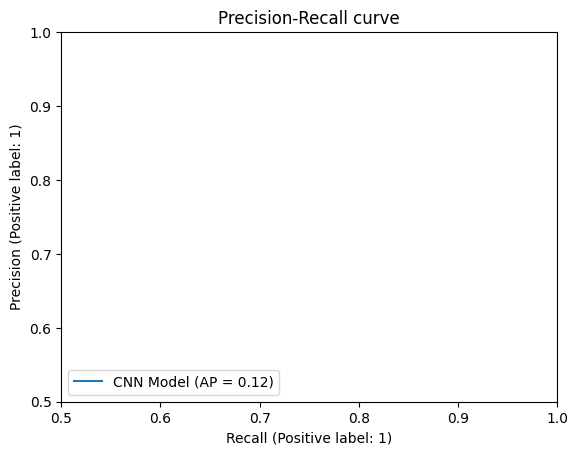

In [51]:
vgg16_model,vgg16_history


f1, accuracy, convergence = evaluate_model(vgg16_model,vgg16_history, X_bnmrk, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"")

**Evaluate Resnet50 on benchmark data**

20/20 [==============================] - 8s 440ms/step
F1 score: 0.9032
Accuracy: 0.8867



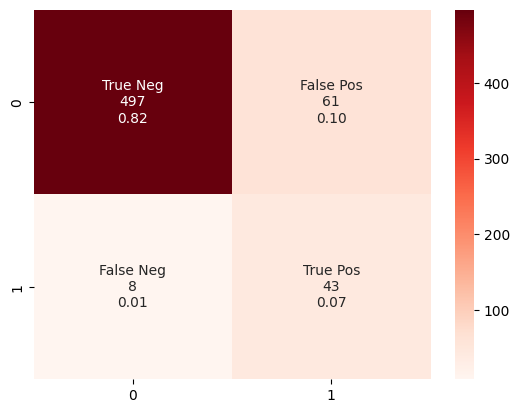

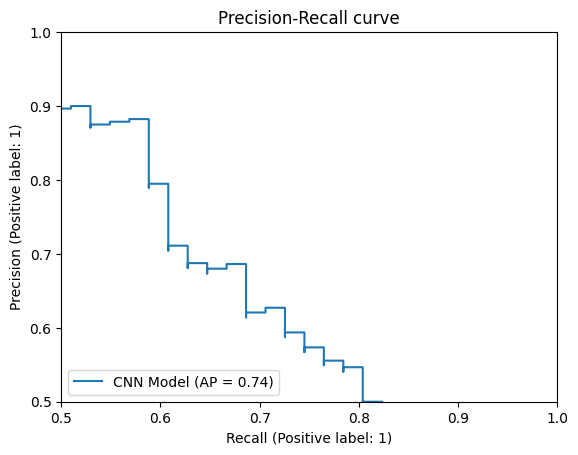

In [55]:
f1, accuracy, convergence = evaluate_model(resnet50_model,resnet50_history, X_bnmrk, y_bnmrk_onehot)

# Print the results
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"")